In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats


from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
#from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.Fingerprints.FingerprintMols import FingerprintMol


from gensim.models import Word2Vec
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec, mol2sentence
from mol2vec.helpers import depict_identifier, mol_to_svg, IdentifierTable, plot_2D_vectors
import joblib
import networkx as nx
from networkx.algorithms import bipartite


from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
import seaborn as sns
import multiprocessing as mp
import xml.etree.ElementTree as ET
import itertools

import os
import csv
import gzip
import collections
import re
import io
import json


import matplotlib
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.size'] = 15

In [8]:
def get_list_atoms(args):
    smile = args
    mol = Chem.MolFromSmiles(smile)
    if mol is not None:
        return [smile,mol.GetNumAtoms(),[at.GetSymbol() for at in mol.GetAtoms()]]
    else:
        return [smile,0,0]

# Load DrugBank

In [ ]:
# path to new data
path_update='/data/sars-busters-consolidated/Database files/'

In [3]:
#DrugBank
DB_df_clean_PubChem_Fetch=joblib.load(path_update+'DB_df_clean_PubChem_Fetch.pkl')
print(DB_df_clean_PubChem_Fetch.shape)
DB_df_clean_PubChem_Fetch.head()

(25579, 18)


,actions,drug_CID,drug_SID,drug_groups,drug_id,drug_inchi,drug_inchi_key,drug_iupac,drug_name,drug_smiles,drug_type,organism,target_aa_sequence,target_category,target_gene_sequence,target_id,target_name,target_uniprot_id
30,inhibitor,None,None,approved|investigational,DB00006,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,OIRCOABEOLEUMC-GEJPAHFPSA-N,(4S)-4-[(2S)-2-[(2S)-2-[(2S)-2-{2-[(2S)-2-(2-{...,Bivalirudin,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,small molecule,Humans,>lcl|BSEQ0016004|Prothrombin\nMAHVRGLQLPGCLALA...,target,>lcl|BSEQ0016005|Prothrombin (F2)\nATGGCGCACGT...,BE0000048,Prothrombin,P00734
31,inhibitor,None,None,approved|investigational,DB00006,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,OIRCOABEOLEUMC-GEJPAHFPSA-N,(4S)-4-[(2S)-2-[(2S)-2-[(2S)-2-{2-[(2S)-2-(2-{...,Bivalirudin,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,small molecule,Humans,>lcl|BSEQ0002139|Myeloperoxidase\nMGVPFFSSLRCM...,enzyme,>lcl|BSEQ0016304|Myeloperoxidase (MPO)\nATGGGG...,BE0001075,Myeloperoxidase,P05164
32,agonist,None,None,approved|investigational,DB00007,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,GFIJNRVAKGFPGQ-LIJARHBVSA-N,(2S)-1-[(2S)-5-carbamimidamido-2-[(2S)-2-[(2R)...,Leuprolide,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,small molecule,Humans,>lcl|BSEQ0000405|Gonadotropin-releasing hormon...,target,>lcl|BSEQ0018926|Gonadotropin-releasing hormon...,BE0000203,Gonadotropin-releasing hormone receptor,P30968
33,substrate,None,None,approved|investigational,DB00007,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,GFIJNRVAKGFPGQ-LIJARHBVSA-N,(2S)-1-[(2S)-5-carbamimidamido-2-[(2S)-2-[(2R)...,Leuprolide,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,small molecule,Humans,>lcl|BSEQ0021936|Cytochrome P450 3A4\nMALIPDLA...,enzyme,>lcl|BSEQ0021937|Cytochrome P450 3A4 (CYP3A4)\...,BE0002638,Cytochrome P450 3A4,P08684
56,agonist,None,None,approved,DB00014,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,BLCLNMBMMGCOAS-URPVMXJPSA-N,(2S)-1-[(2S)-2-[(2S)-2-[(2R)-3-(tert-butoxy)-2...,Goserelin,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,small molecule,Humans,>lcl|BSEQ0036957|Lutropin-choriogonadotropic h...,target,>lcl|BSEQ0010174|Lutropin-choriogonadotropic h...,BE0000134,Lutropin-choriogonadotropic hormone receptor,P22888


In [4]:
DB_drugs=DB_df_clean_PubChem_Fetch.drop_duplicates(subset=['drug_smiles'])
DB_drugs=DB_drugs[[col for col in DB_drugs.columns if 'drug' in col]]
print(DB_drugs.shape)
DB_drugs.head()

(7314, 10)


,drug_CID,drug_SID,drug_groups,drug_id,drug_inchi,drug_inchi_key,drug_iupac,drug_name,drug_smiles,drug_type
30,None,None,approved|investigational,DB00006,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,OIRCOABEOLEUMC-GEJPAHFPSA-N,(4S)-4-[(2S)-2-[(2S)-2-[(2S)-2-{2-[(2S)-2-(2-{...,Bivalirudin,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,small molecule
32,None,None,approved|investigational,DB00007,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,GFIJNRVAKGFPGQ-LIJARHBVSA-N,(2S)-1-[(2S)-5-carbamimidamido-2-[(2S)-2-[(2R)...,Leuprolide,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,small molecule
56,None,None,approved,DB00014,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,BLCLNMBMMGCOAS-URPVMXJPSA-N,(2S)-1-[(2S)-2-[(2S)-2-[(2R)-3-(tert-butoxy)-2...,Goserelin,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,small molecule
95,None,None,approved,DB00027,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,NDAYQJDHGXTBJL-MWWSRJDJSA-N,(2R)-N-[(1S)-1-{[(1R)-1-{[(1S)-1-{[(1R)-1-{[(1...,Gramicidin D,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,small molecule
138,None,None,approved,DB00035,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,NFLWUMRGJYTJIN-PNIOQBSNSA-N,"(2R)-2-{[(2S)-1-[(4R,7S,10S,13S,16S)-13-benzyl...",Desmopressin,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,small molecule


# Load NDM

In [6]:
#NDM
#NDM=pd.read_csv('/Users/giulia/Dropbox (CCNR)/Foodome Team Folder/FOODOME/Periodic_Table_of_Food_Data/NDM_Master.csv')
NDM=joblib.load(path_update+'NDM_Master_FingerPrints_InChi.pkl')
print(NDM.shape)
NDM.head()

(19603, 59)


,name,InChIKey,First Block,Metabolon_RP,UCD_GC,UCD_HIL,UCD_LIP,UCD_PFP,phenolexplorer_id,dfc_id,...,hbondacc,rotbonds,dois,InChiKey,cid,fingerprint_r2,fingerprint,fingerprint_vector,fingerprint_r2_vector,glove_vector
0,"1,5,8-Trihydroxy-3-methyl-2-prenylxanthone",AAANZTDKTFGJLZ-UHFFFAOYSA-N,AAANZTDKTFGJLZ,NaN,NaN,NaN,NaN,NaN,NaN,HHG46-P:HHG14-E,...,6.0,3.0,10.1007/978-94-007-1764-0_15,AAANZTDKTFGJLZ-UHFFFAOYSA-N,14162674.0,2246728737 3545365497 2246699815 176403689 224...,2246728737 3545365497 2246699815 176403689 224...,1.2125952 -0.45228845 -0.45648438 0.8465898 -2...,0.08833204 0.111414164 -0.37103447 0.13921869 ...,0.5982757 0.33405483 -0.7447651 -1.0637729 1.4...
1,"2,4-Dimethylfuran",AABTWRKUKUPMJG-UHFFFAOYSA-N,AABTWRKUKUPMJG,NaN,NaN,NaN,NaN,NaN,NaN,FWS22-S:FWS22-S,...,1.0,0.0,10.1007/978-3-642-41473-2_4|10.1007/978-94-007...,AABTWRKUKUPMJG-UHFFFAOYSA-N,19462.0,2246728737 422715066 3217380708 3661262542 321...,2246728737 422715066 3217380708 3661262542 321...,0.7780322 -0.008117993 -0.31886604 -0.08983363...,0.05996513 0.058616612 -0.16668518 0.08901948 ...,0.7881843 -0.11993383 -1.035832 -1.1379453 1.3...
2,Schidigerasaponin E1,AADIIQJBIMAADJ-UHFFFAOYSA-N,AADIIQJBIMAADJ,NaN,NaN,NaN,NaN,NaN,NaN,GMN25-P:JYJ15-F,...,18.0,8.0,NaN,AADIIQJBIMAADJ-UHFFFAOYSA-N,73798945.0,2246728737 1858577693 2976033787 1228815484 29...,2246728737 1858577693 2976033787 1228815484 29...,-0.13111542 -2.1445282 -1.7001715 -0.793216 -1...,-0.010426988 0.058215413 -0.17470427 0.3262831...,0.45775712 1.4772747 -0.8142888 0.24698713 0.6...
3,sphingomyelin (d18:1/20:0),AADLTHQNYQJHQV-SVLGDMRNSA-N,AADLTHQNYQJHQV,100006290.0,NaN,NaN,L489,NaN,NaN,NaN,...,6.0,40.0,10.1038/s41598-018-28477-9,AADLTHQNYQJHQV-SVLGDMRNSA-N,44260124.0,2246728737 3542456614 2245384272 1173125914 22...,2246728737 3542456614 2245384272 1173125914 22...,1.1118712 -3.3872707 0.19861576 2.4934237 -0.0...,0.17508355 -0.19388516 -0.33345646 0.13449408 ...,0.47446114 0.31419408 0.03206512 -1.0402479 0....
4,Matairesinoside,AAGCATAPYOEULE-LHHMAMHXSA-N,AAGCATAPYOEULE,NaN,NaN,NaN,NaN,NaN,NaN,JRV93-M:JJJ08-E,...,11.0,9.0,10.1016/j.bmcl.2013.08.065|10.1016/j.fitote.20...,AAGCATAPYOEULE-LHHMAMHXSA-N,486612.0,2246728737 3975275337 864674487 2076190208 321...,2246728737 3975275337 864674487 2076190208 321...,0.46425006 -0.7574755 -1.289255 0.8256081 -2.9...,0.080369376 0.053641893 -0.3176836 0.17028345 ...,0.47634116 0.8720007 -0.7416479 -0.7085184 1.2...


In [7]:
# drop chemicals without chemical smiles (there are repetitions give the stereochemistry)
print(sum(NDM['SMILE'].notnull()))
NDM=NDM.dropna(subset=['SMILE'])
print(NDM.shape)

19603
(19603, 59)


In [10]:
# Atoms statistics in DrugBank
p = Pool(8)
atoms_DB = p.map(get_list_atoms,
                            [smile for smile in DB_drugs.drug_smiles])
#joblib.dump(atoms_DB, 'atoms_DB.pkl')

atoms_DB_df = pd.DataFrame(columns = ['drug_smiles', 'num_atoms', 'list_atoms'])
atoms_DB_df['drug_smiles'] = [p[0] for p in atoms_DB]
atoms_DB_df['num_atoms'] = [p[1] for p in atoms_DB]
atoms_DB_df['list_atoms'] = [p[2] for p in atoms_DB]

RDKit ERROR: [15:16:59] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [15:16:59] Explicit valence for atom # 14 N, 5, is greater than permitted
RDKit ERROR: [15:16:59] Explicit valence for atom # 13 Cl, 5, is greater than permitted
RDKit ERROR: [15:16:59] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [15:16:59] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [15:17:00] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [15:17:00] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [15:17:00] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [15:17:00] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [15:17:00] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [15:17:00] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [15:17:00] Explicit valence for atom

In [11]:
# Atoms statistics in NDM
p = Pool(8)
atoms_NDM = p.map(get_list_atoms,
                            [smile for smile in NDM.SMILE])
#joblib.dump(atoms_NDM, 'atoms_NDM.pkl')

atoms_NDM_df = pd.DataFrame(columns = ['SMILE', 'num_atoms', 'list_atoms'])
atoms_NDM_df['SMILE'] = [p[0] for p in atoms_NDM]
atoms_NDM_df['num_atoms'] = [p[1] for p in atoms_NDM]
atoms_NDM_df['list_atoms'] = [p[2] for p in atoms_NDM]

RDKit WARNING: [15:17:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:17:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:17:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:17:03] WARNING: not removing hydrogen atom without neighbors


In [12]:
# Filter
atoms_DB_df=atoms_DB_df[atoms_DB_df.num_atoms>0]
print(atoms_DB_df.shape)
atoms_NDM_df=atoms_NDM_df[atoms_NDM_df.num_atoms>0]
print(atoms_NDM_df.shape)

(7299, 3)
(19603, 3)


(0.0, 600.0)

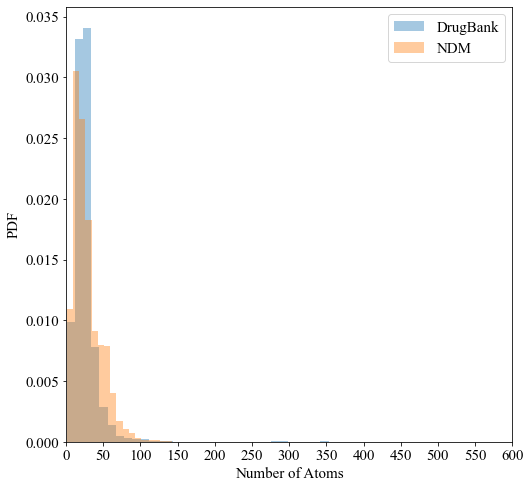

In [23]:
# number of atoms per compound
plt.figure(figsize = (8, 8))
ax = sns.distplot(atoms_DB_df['num_atoms'], norm_hist=True, kde=False, label='DrugBank')          
sns.distplot(atoms_NDM_df['num_atoms'], norm_hist=True, kde=False, ax=ax, label='NDM')
ax.set_xlabel('Number of Atoms')
ax.set_ylabel('PDF')
plt.legend()
plt.xticks(np.arange(0, 650, step=50), np.arange(0, 650, step=50))
plt.xlim([0,600])

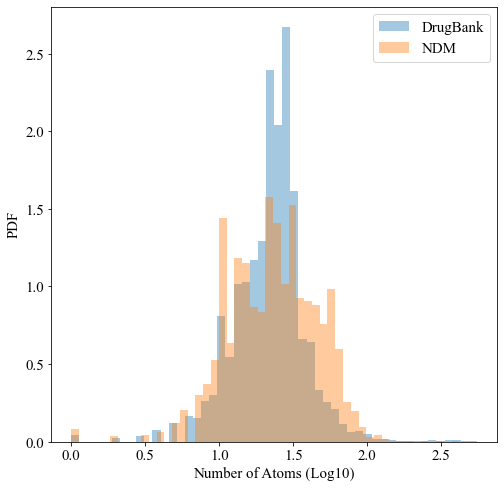

In [24]:
# number of atoms in a chemical (log10)
plt.figure(figsize = (8, 8))
ax = sns.distplot(atoms_DB_df['num_atoms'].apply(np.log10), norm_hist=True, kde=False, label='DrugBank')          
sns.distplot(atoms_NDM_df['num_atoms'].apply(np.log10), norm_hist=True, kde=False, ax=ax, label='NDM')
ax.set_xlabel('Number of Atoms (Log10)')
ax.set_ylabel('PDF')
plt.legend()

In [18]:
# atoms analysis 
listatoms_DB=list(itertools.chain.from_iterable(atoms_DB_df.list_atoms))
listatoms_NDM=list(itertools.chain.from_iterable(atoms_NDM_df.list_atoms))
counterDB=collections.Counter(listatoms_DB)
counterDBkey=sorted(counterDB, key=counterDB.get, reverse=True)
counterNDM=collections.Counter(listatoms_NDM)
counterNDMkey=sorted(counterNDM, key=counterNDM.get, reverse=True)

atoms_summary = pd.DataFrame(columns = ['atom', 'prevalence', 'source'])
atoms_summary['atom'] = counterDBkey+counterNDMkey
atoms_summary['prevalence'] = [counterDB[k]/len(listatoms_DB) for k in counterDBkey]+[counterNDM[k]/len(listatoms_NDM) for k in counterNDMkey]
atoms_summary['source'] = (['DrugBank']*len(counterDBkey))+(['NDM']*len(counterNDMkey))
atoms_summary

,atom,prevalence,source
0,C,0.685876,DrugBank
1,O,0.172945,DrugBank
2,N,0.103214,DrugBank
3,S,0.011878,DrugBank
4,F,0.009527,DrugBank
...,...,...,...
116,Sb,0.000002,NDM
117,W,0.000002,NDM
118,Re,0.000002,NDM
119,Ar,0.000002,NDM


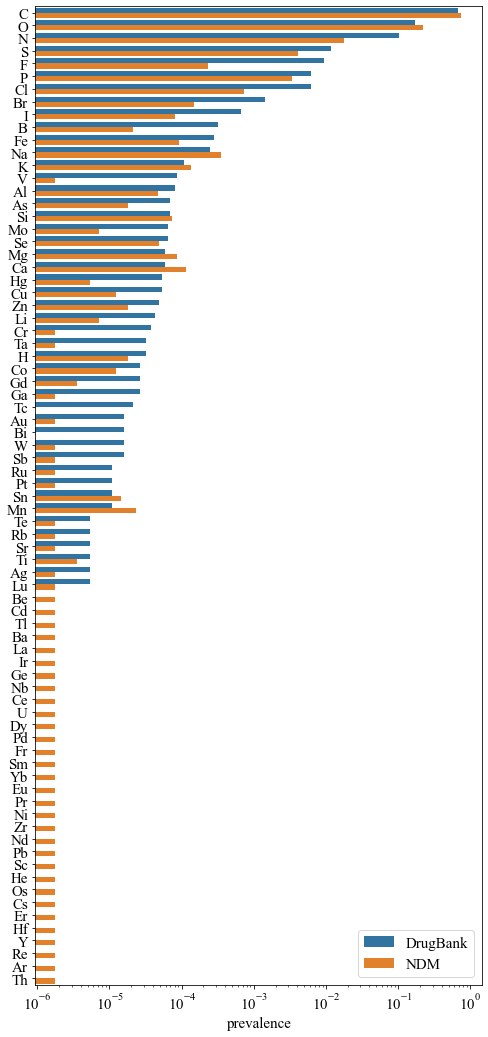

In [26]:
plt.figure(figsize = (8, 18))
ax = sns.barplot(x = 'prevalence', y='atom', data=atoms_summary, hue='source')
ax.set_ylabel('')
ax.set_xscale('log')
plt.legend(loc='lower right');